In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import unquote
from tqdm import tqdm 

dataFolder = '../Data/wikispeedia_paths-and-graph/'
articlesDf = pd.read_csv(dataFolder+ 'articles.tsv')
articlesDf = articlesDf.iloc[10:]
articlesSeries  = pd.Series(articlesDf.index.map(lambda x : x[0])).map(lambda y : unquote(y,'utf-8'))
#articlesSeries.head(10)

linksDf = pd.read_csv(dataFolder + 'links.tsv', header=11, sep = '\t')
linksDf.columns = ['Elements','links']
linksDf['Elements'] = linksDf['Elements'].map(lambda x : unquote(x, 'utf-8'))
linksDf['links'] = linksDf['links'].map(lambda x : unquote(x, 'utf-8'))
#linksDf.reset_index()

categoriesDf = pd.read_csv(dataFolder + 'categories.tsv', header=11, sep= '\t')
categoriesDf.index = categoriesDf.index.map(lambda x : unquote(x,'utf-8'))
categoriesDf.columns = ['categories']
#categoriesDf

paths_finishedDf= pd.read_csv(dataFolder + 'paths_finished.tsv', header=15, sep= '\t')
paths_finishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'rating']
#paths_finishedDf

paths_unfinishedDf= pd.read_csv(dataFolder + 'paths_unfinished.tsv', header=16, sep= '\t')
paths_unfinishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'target', 'type']
#paths_unfinishedDf

people_skin_color = pd.read_csv(dataFolder + 'people_with_skin_color.tsv', header=1, sep= '\t' )
people_skin_color.columns = ['Category', 'People', 'Skin Color']
people_skin_color['People'] = people_skin_color['People'].map(lambda x : unquote(x, 'utf-8'))
people_skin_color.reset_index()
people_skin_color

1. Distribution of articles in each categories 


The dataset 'categories' contains main categories and then sub-categories. We will focus on main categories.

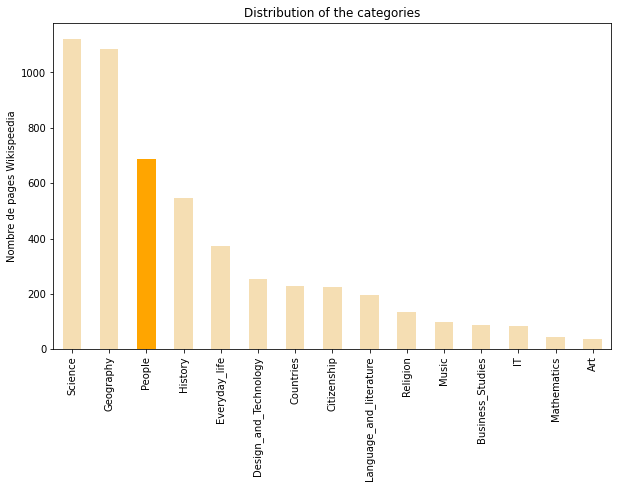

In [50]:
categories_details = categoriesDf["categories"].str.split(".", expand=True)

#keep only the main category
categories = categories_details[1]
categories = pd.DataFrame(categories)
categories = categories.rename(columns = {1 : 'Main Categories'})
categories_distribution=categories['Main Categories'].value_counts()

#Vizualise the distribution 
plt.figure(figsize=(10, 6))  
colors = ['wheat' if cat != 'People' else 'orange' for cat in categories_distribution.index]
categories_distribution.plot(kind='bar', color=colors)
plt.title('Distribution of the categories')
plt.xlabel(' ')
plt.ylabel('Nombre de pages Wikispeedia')
plt.show()

People is the third category containing the bigger amount of articles (around 700 articles). We will know focus on this category and used our new dataset 'people_with_skin_color.tsv'

2. The ethnics distribution whitin people articles

To continue, we will focus on the ethnics distribution whithin the people articles. 

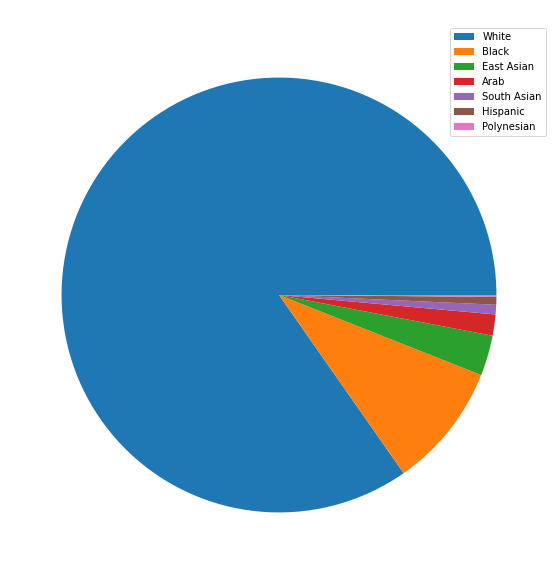

In [87]:
people_color =  pd.concat([people_skin_color, people_skin_color['Category'].str.split(".", expand=True)], axis=1)
people_color = people_color.drop(columns = ['Category', 0, 1])
people_color = people_color.rename(columns = {1 : 'Categories'})

unique_color=people_color['Skin Color'].unique()
rename = {
    'Blanc' : 'White',
    'Peau plus foncée' : 'Black',
    'Peau brune' : 'Black',
    'Peau plus foncée (Aborigène australien)' : 'Black',
    'Peau plus foncée (Asiatique)' : 'East Asian', 
    'Peau plus foncée (Moyen-Orient)' : 'Arab',
    'Peau plus foncée (Polynésien)' : 'Polynesian',
    'Peau plus foncée (Sherpa/Népalais)' : 'South Asian', 
    'Peau plus foncée (Ascendance africaine partielle)' : 'Black', 
    'Peau plus foncée (Indien)' : 'South Asian',
    'Peau plus foncée (Berbère)' : 'Arab',
    'Peau plus foncée (Arabe)' : 'Arab',
    'Peau plus foncée (Tibétain)' : 'East Asian',
    'Peau plus foncée (Persan)' : 'Arab',
    'Peau plus foncée (Juif)' : 'Arab', 
    'Peau plus foncée (Somalienne)' : 'Black', 
    'Peau plus foncée (Mixte)' : 'Black',
    'Peau plus foncée (Hispanique)' : 'Hispanic', 
    'Peau plus foncée (Indonésien)' : 'East Asian', 
    'Peau plus foncée (Japonais)' : 'East Asian',
    'Peau plus foncée (Vietnamien)' : 'East Asian', 
    'Peau plus foncée (Indienne)' : 'South Asian', 
    'Peau brune (Indien)' : 'South Asian',
    'Peau plus foncée (Palestinien)' : 'Arab',
    'Peau brune (Pakistano-Indien)' : 'South Asian', 
    "Blanc (D'origine libanaise)": 'White', 
    'Peau plus foncée (Brésilien)' : 'Hispanic'
}
people_color['Skin Color'] = people_color['Skin Color'].replace(rename)
people_color_dist=people_color['Skin Color'].value_counts()

#Vizualise the data
plt.figure(figsize=(10, 10))  
plt.pie(people_color_dist)
plt.title('Répartition des catégories')
plt.legend(people_color_dist.index)
plt.show()



So the distribution of white people is way more bigger than the representation of the other ethnics groups. Wikispeedia contains more article about white personalities. This already show the inequal representation of the different ethnics groups within the game.